# Цель
На основании данных о продажах, посещениях и маркетинговых затратах сервиса Яндекс.Афиша необходимо определить сколько денег приносят клиенты, и как быстро окупаются маркетинговые затраты.

# Результат
Рассчитаны продуктовые метрики: DAU, WAU, MAU, Retention, LTV, CAC, ROMI, средний чек, продолжительность одной сессии, время до первой покупки. Найдено время окупаемости маркетинговых затрат в разрезе когорт и источников трафика.



### [Шаг 1. Загрузите данные и подготовьте их к анализу](#stage_1)
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. 

### Файлы
- visits_log.csv
- orders_log.csv
- costs.csv

### Задачи
- Предобработка visits
- Предобработка orders
- Предобработка costs


### [Шаг 2. Постройте отчёты и посчитайте метрики](#stage_2)

#### [Продукт](stage_2_1)
- Сколько людей пользуются в день, неделю, месяц? ( DAU, WAU, MAU )
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?
- Retention Rate

#### [Продажи](#stage_2_2)
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)


#### [Маркетинг](stage_2_2)
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI) ( в данном случае затраты только на источник, поэтомуц можно исп. ROI )
- Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?



### [Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?](stage_3)
- Какие источники/платформы вы бы порекомендовали? 
- Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? 
- Какие выводы вы сделали, узнав значение метрик?




# Описание данных


## Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


## Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа


## Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### [Шаг 1. Загрузите данные и подготовьте их к анализу](#stage_1)

##### Предобработка visits_log.csv

In [231]:
data_visit_log = pd.read_csv('visits_log.csv')
data_visit_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [232]:
data_visit_log['Device'].unique()

array(['touch', 'desktop'], dtype=object)

touch - смартфоны
desktop - компьютер

In [233]:
data_visit_log['End Ts'] = pd.to_datetime(data_visit_log['End Ts'])
data_visit_log['Start Ts'] = pd.to_datetime(data_visit_log['Start Ts'])
data_visit_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [234]:
# Смотрим на дубликаты

data_visit_log.duplicated().sum()

0

##### Предобработка order_log.csv

In [235]:
data_orders_log = pd.read_csv('orders_log.csv')
data_orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [236]:
data_orders_log['Buy Ts'] = pd.to_datetime(data_orders_log['Buy Ts'])
data_orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [237]:
# Смотрим на дубликаты

data_orders_log.duplicated().sum()

0

##### Предобработка costs

In [238]:
data_costs = pd.read_csv('costs.csv')
data_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [239]:
data_costs['dt'] = pd.to_datetime(data_costs['dt'])
data_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [240]:
# Смотрим на дубликаты

data_costs.duplicated().sum()

0

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [Шаг 2. Постройте отчёты и посчитайте метрики](#stage_2)

#### [Продукт](stage_2_1)

In [241]:
data_visit_log['day_visit'] = data_visit_log['Start Ts'].dt.day
data_visit_log['week_visit'] = data_visit_log['Start Ts'].dt.week
data_visit_log['month_visit'] = data_visit_log['Start Ts'].dt.month
data_visit_log['date'] = data_visit_log['Start Ts'].dt.date.astype('datetime64[D]')
data_visit_log['year_visit'] = data_visit_log['Start Ts'].dt.year
data_visit_log.head()

C:\Users\oudel\AppData\Local\Temp\ipykernel_15192\1432500.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_visit_log['week_visit'] = data_visit_log['Start Ts'].dt.week


,Device,End Ts,Source Id,Start Ts,Uid,day_visit,week_visit,month_visit,date,year_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017-12-20,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018-02-19,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017-07-01,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018-05-20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017-12-27,2017


##### 1) Сколько людей пользуются в день, неделю, месяц?

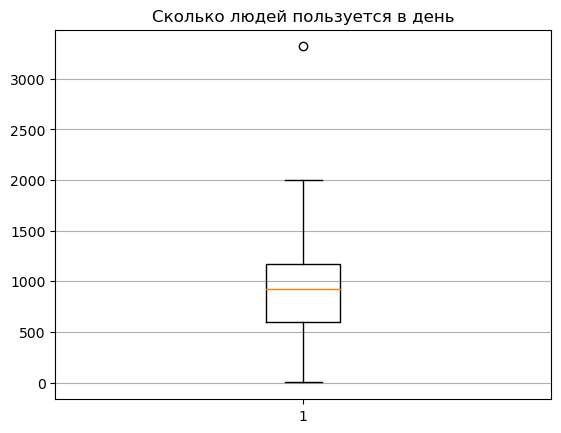

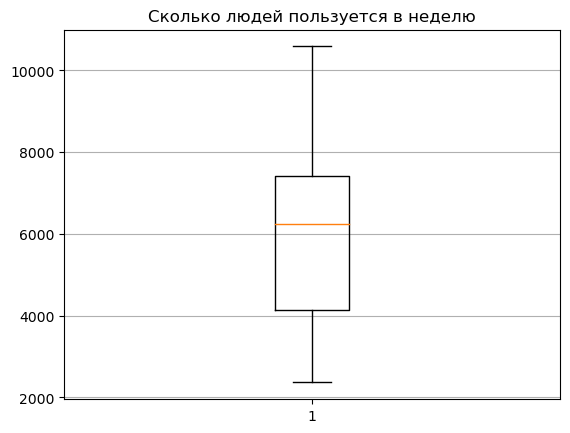

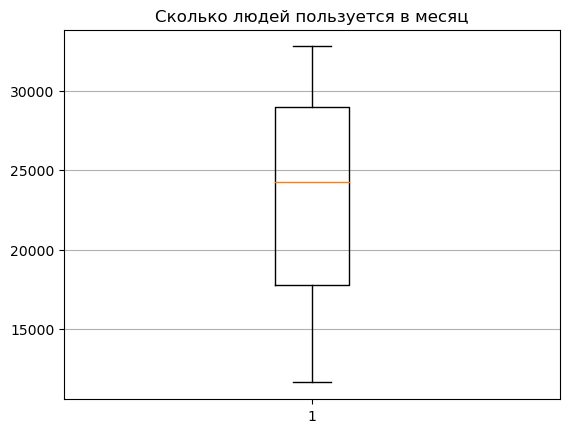

In [242]:
# Проверка на выбросы по каждому из вопросов (отвечаем на вопрос: Что использовать: mean или median)

viborka1 = data_visit_log.groupby('date').agg({'Uid': 'nunique'})['Uid']

plt.boxplot(viborka1)
plt.title('Сколько людей пользуется в день')
plt.grid(axis = 'y')
plt.show()

viborka2 = data_visit_log.groupby('week_visit').agg({'Uid': 'nunique'})['Uid']

plt.boxplot(viborka2)
plt.title('Сколько людей пользуется в неделю')
plt.grid(axis = 'y')
plt.show()

viborka3 = data_visit_log.groupby('month_visit').agg({'Uid':'nunique'})['Uid']

plt.boxplot(viborka3)
plt.title('Сколько людей пользуется в месяц')
plt.grid(axis = 'y')
plt.show()


Выбросов нет --> используем среднее

In [243]:
day_visit_unique = data_visit_log.groupby('date').agg({'Uid': 'nunique'}).mean().round(2)
print(f'Уникальных визитов в день:  {day_visit_unique[0]}')


week_visit_unique = data_visit_log.groupby(['year_visit','week_visit']).agg({'Uid': 'nunique'}).mean().round(2)
print(f'Уникальных визитов в неделю:  {week_visit_unique[0]}')


month_visit_unique = data_visit_log.groupby('month_visit').agg({'Uid':'nunique'}).mean().round(2)
print(f'Уникальных визитов в месяц:  {month_visit_unique[0]}')

Уникальных визитов в день:  907.99
Уникальных визитов в неделю:  5716.25
Уникальных визитов в месяц:  23228.42


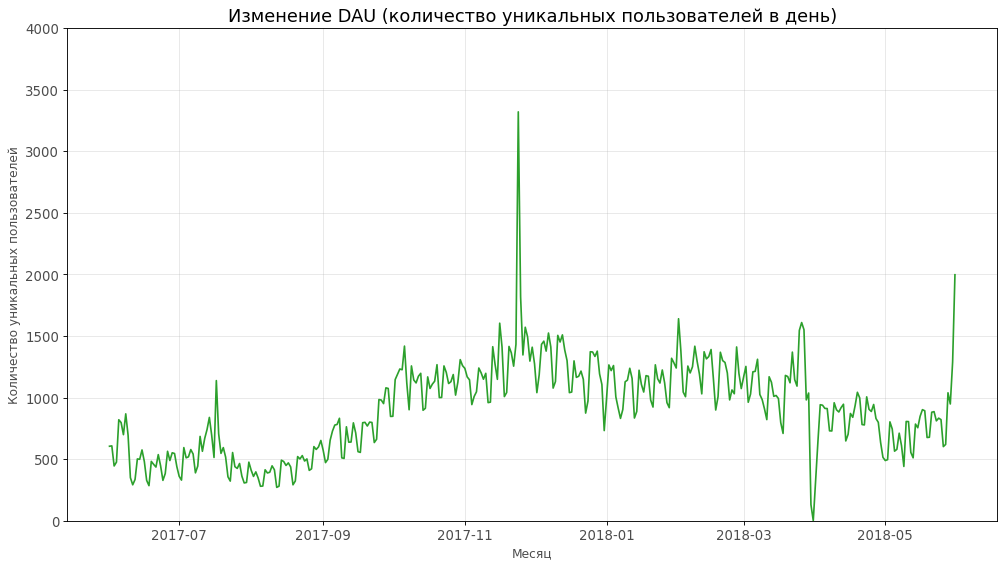

In [244]:
day_visit_unique = data_visit_log.groupby('date').agg({'Uid': 'nunique'}).reset_index()


#Построим графики изменения DAU метрики во времени
plt.figure(figsize=(15,8), dpi = 80)
plt.plot('date',
         'Uid',
         data = day_visit_unique,
         color='tab:green')

plt.ylim(0, 4000)
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Месяц', fontsize = 11, alpha = 0.7)
plt.ylabel('Количество уникальных пользователей', fontsize=11, alpha = 0.7)
plt.title("Изменение DAU (количество уникальных пользователей в день)", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.show()


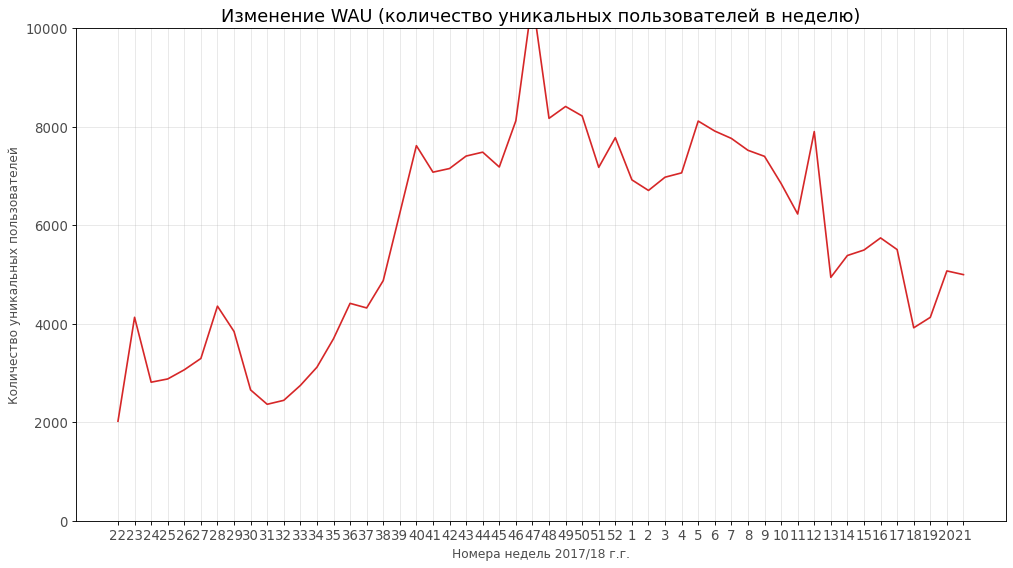

In [245]:
week_visit_unique = data_visit_log.groupby(['year_visit','week_visit']).agg({'Uid': 'nunique'}).reset_index()

#Построим графики изменения WAU метрики во времени
plt.figure(figsize=(15,8), dpi = 80)
plt.plot([str(x) for x in week_visit_unique['week_visit'][:52]],
         week_visit_unique['Uid'][:52],
         color='tab:red')

plt.ylim(0, 10000)
plt.xticks(rotation=0, fontsize=12, alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Номера недель 2017/18 г.г.', fontsize = 11, alpha = 0.7)
plt.ylabel('Количество уникальных пользователей', fontsize=11, alpha = 0.7)
plt.title("Изменение WAU (количество уникальных пользователей в неделю)", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.show()

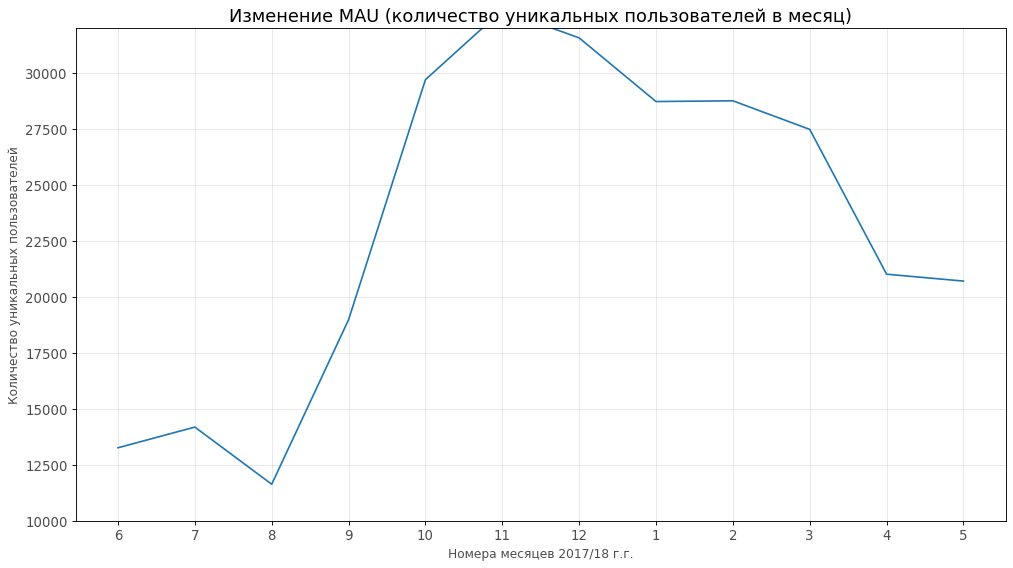

In [246]:
month_visit_unique = data_visit_log.groupby(['year_visit','month_visit']).agg({'Uid':'nunique'}).reset_index()

#Построим графики изменения MAU метрики во времени
plt.figure(figsize=(15,8), dpi = 80)
plt.plot([str(x) for x in month_visit_unique['month_visit']],
         month_visit_unique['Uid'],
         color='tab:blue')

plt.ylim(10000, 32000)
plt.xticks(rotation=0, fontsize=12, alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Номера месяцев 2017/18 г.г.', fontsize = 11, alpha = 0.7)
plt.ylabel('Количество уникальных пользователей', fontsize=11, alpha = 0.7)
plt.title("Изменение MAU (количество уникальных пользователей в месяц)", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.show()

- Уникальных пользователей в день (в среднем): 908
- Уникальных пользователей в неделю (в среднем): 5716
- Уникальных пользователей в месяц (в среднем): 23228


- зафиксирован резкий скачек роста уникальных пользователей 24 ноября 2017 г.
- также зафиксировано резкое падение 31 марта 2017 г.
- в конце августа 2017 г. был рост дневных уникальльных пользователей, а в марте 2018 г. показатель снизился
- под конец 2017 года кол-во уникальных посещений увеличилось, а далее было понижение

Причина таких цифр - трудно объяснима ( например в ноябре 2017 г. -  пик, а в августе 2017 г. - падение, хотя август - месяц отпусков )
Возможно это связано с рекламными компаниями проведенными ( или не проведенными ) в эти периоды 


##### 2) Сколько сессий в день?

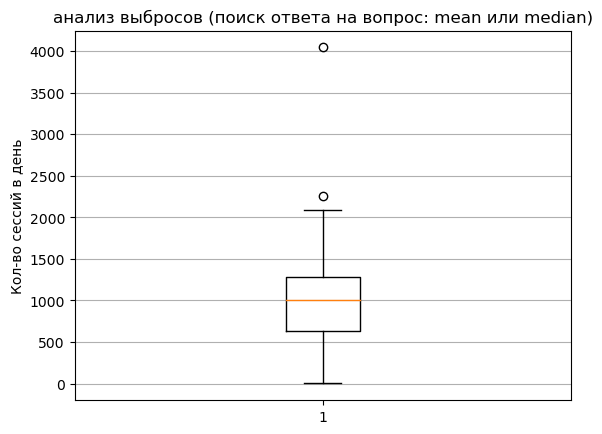

In [247]:
plt.boxplot(data_visit_log.groupby('date')['date'].count())
plt.ylabel('Кол-во сессий в день')
plt.title('анализ выбросов (поиск ответа на вопрос: mean или median)')
plt.grid(axis = 'y')      # есть несколько выбросов --> не значительны --> оставим их --> считаем среднее

In [248]:
session_per_day = data_visit_log.groupby('date')['date'].count().mean()
print(f'Сессий в день: {session_per_day.round(2)}')

Сессий в день: 987.36


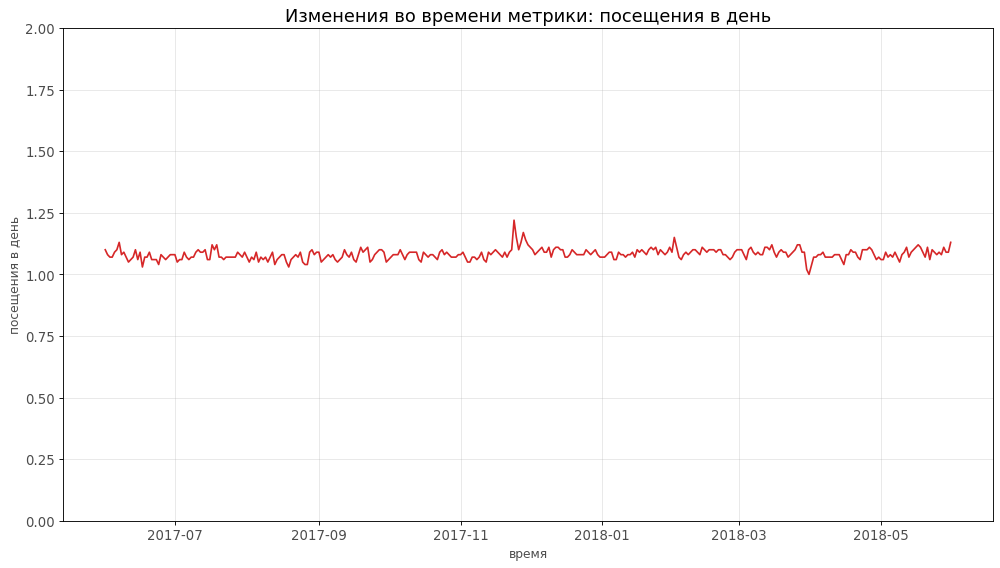

In [249]:
session_per_day = data_visit_log.groupby('date').agg({'Uid': ['count' ,'nunique'] }).reset_index()
session_per_day['Посещений в день'] = (session_per_day[('Uid', 'count')] / session_per_day[('Uid', 'nunique')]).round(2)

#Построим графики изменения метрики во времени
plt.figure(figsize=(15,8), dpi = 80)
plt.plot('date',
         'Посещений в день',
         data = session_per_day,
         color='tab:red')

plt.ylim(0, 2)
plt.xticks(fontsize=12, alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('время', fontsize = 11, alpha = 0.7)
plt.ylabel('посещения в день', fontsize=11, alpha = 0.7)
plt.title("Изменения во времени метрики: посещения в день", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.show()


Метрика стабильна - есть небольшие скачки в конце ноября и в коце марта

##### 3) Сколько длится одна сессия?

In [250]:
(data_visit_log['End Ts'] - data_visit_log['Start Ts']).dt.total_seconds().describe().round(2)       # есть отрицательные значения --> посмотрим сколько их (большАя ли часть выборки)

count    359400.00
mean        643.03
std         997.13
min       -2760.00
25%         120.00
50%         300.00
75%         840.00
max       42660.00
dtype: float64

In [251]:
data_visit_log['session_seconds'] = (data_visit_log['End Ts'] - data_visit_log['Start Ts']).dt.total_seconds()
data_visit_log[data_visit_log['session_seconds'] < 0]   # видим очевидно неккоректные данные по старту и концу сессии (конец левее на временной прямой)
                                                        # всего 2 сессии ---> удалим их

,Device,End Ts,Source Id,Start Ts,Uid,day_visit,week_visit,month_visit,date,year_visit,session_seconds
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,25,12,3,2018-03-25,2018,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,25,12,3,2018-03-25,2018,-2760.0


Text(0.5, 1.0, 'анализ выбросов (поиск ответа на вопрос : median или mean)')

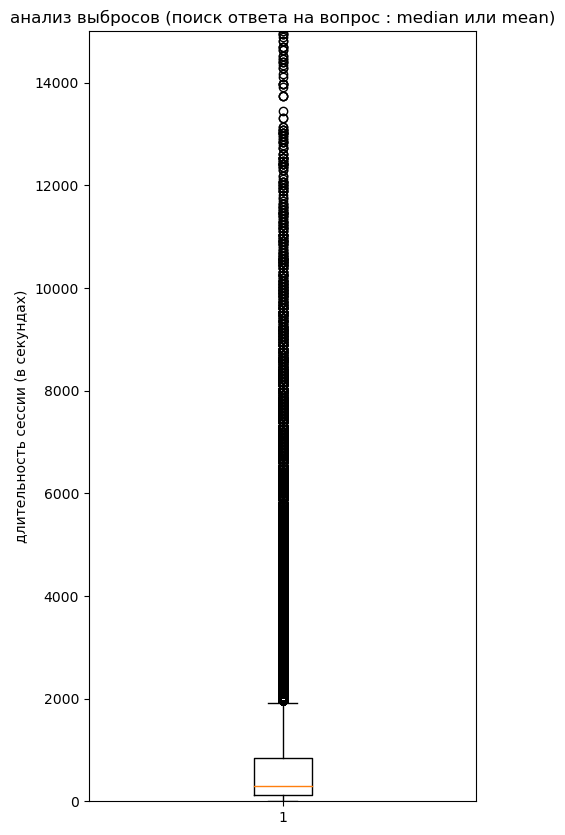

In [252]:
plt.figure(figsize=(5,10))
plt.boxplot(data_visit_log['session_seconds'])
plt.ylim((0,15000))
plt.ylabel('длительность сессии (в секундах)')
plt.title('анализ выбросов (поиск ответа на вопрос : median или mean)')

In [253]:
data_visit_log = data_visit_log[data_visit_log['session_seconds'] > 0]
session_seconds = data_visit_log['session_seconds'].median()
print(f'Медианная длительность сессии (в секундах): {session_seconds}')

Медианная длительность сессии (в секундах): 360.0


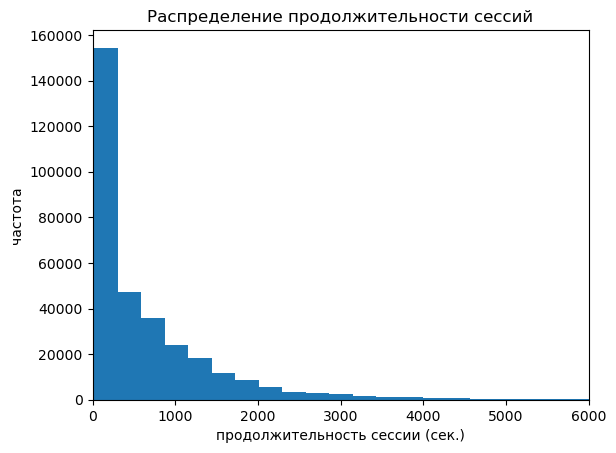

count    323604.00
mean        714.17
std        1026.35
min          19.00
25%         120.00
50%         360.00
75%         900.00
max       42660.00
Name: session_seconds, dtype: float64

In [254]:
data_visit_log['session_seconds'].plot(kind = 'hist',
                                       bins = 150)
plt.xlim((0,6000))
plt.xlabel('продолжительность сессии (сек.)')
plt.ylabel('частота')
plt.title('Распределение продолжительности сессий')
plt.show()

data_visit_log['session_seconds'].describe().round(2)


- Длительность сессии в основном - 1 минута
- Медианное значение - 6 минут

Непродолжительность сессий - это признак правильной навигации сайта ( после кликания на мероприятие следует хорошая информативность )

##### 4) Как часто люди возвращаются?

In [255]:
data_visit_log['month_visit_+_year'] = data_visit_log['date'].dt.to_period('M')
data_visit_log['year_visit'] = data_visit_log['date'].dt.year
data_visit_log = data_visit_log.rename({'month_visit_+_year': 'месяц посещения'}, axis = 1)
data_visit_log.head()

,Device,End Ts,Source Id,Start Ts,Uid,day_visit,week_visit,month_visit,date,year_visit,session_seconds,месяц посещения
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017-12-20,2017,1080.0,2017-12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018-02-19,2018,1680.0,2018-02
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018-05-20,2018,1440.0,2018-05
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,3,35,9,2017-09-03,2017,60.0,2017-09
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,30,5,1,2018-01-30,2018,3360.0,2018-01


In [256]:
data_2 = \
pd.DataFrame(data_visit_log.groupby(['date', 'Uid'])['Uid'].count()).rename({'Uid': 'Сколько раз посетил'}, axis = 1).reset_index()

data_2.head()

,date,Uid,Сколько раз посетил
0,2017-06-01,32197920403662046,1
1,2017-06-01,184148767273119549,2
2,2017-06-01,254239507810036143,1
3,2017-06-01,258099436367309303,1
4,2017-06-01,300776506671194537,1


In [257]:
data_2.pivot_table('date',
                   index = 'Сколько раз посетил',
                   aggfunc='count')

,date
Сколько раз посетил,
1,277317
2,16402
3,2717
4,741
5,261
6,102
7,39
8,12
9,8


In [258]:
data_3 =\
pd.DataFrame(data_visit_log.groupby(['месяц посещения', 'Uid'])['Uid'].count()).rename({'Uid': 'Количество посещений в мес.'}, axis = 1).reset_index()

data_3.head()

,месяц посещения,Uid,Количество посещений в мес.
0,2017-06,297729379853735,1
1,2017-06,407573351275847,1
2,2017-06,1349311730029478,1
3,2017-06,1575281904278712,2
4,2017-06,2471247936243530,2


In [259]:
data_3.pivot_table('месяц посещения',
                   index = 'Количество посещений в мес.',
                   aggfunc = 'count').rename({'месяц посещения': 'Посещений в месяц (ЗА ВЕСЬ ВРЕМЕННОЙ ПЕРИОД)'}, axis = 1).reset_index().head()

,Количество посещений в мес.,Посещений в месяц (ЗА ВЕСЬ ВРЕМЕННОЙ ПЕРИОД)
0,1,215656
1,2,24907
2,3,5947
3,4,1998
4,5,891


В генеральной совокупности посетители посещают сайт 1 раз (и в день и в месяц)
Редкий человек ходит на мероприятия больше 1 раза месяц ---> тем более, больше 1 раза в день

###### 5) Retention Rate

C:\Users\oudel\AppData\Local\Temp\ipykernel_15192\1906606583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohorts_activity['activity_date'] = cohorts_activity['Start Ts'].dt.date
C:\Users\oudel\AppData\Local\Temp\ipykernel_15192\1906606583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohorts_activity['activity_date'] = pd.to_datetime(cohorts_activity['activity_date'])


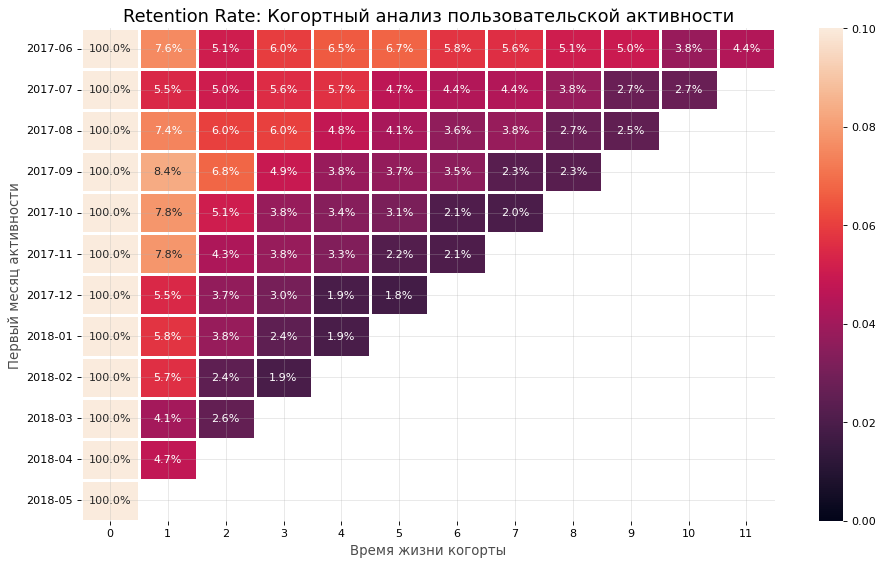

In [260]:
from datetime import datetime
#Создаем датафрейм с данными для когорт
cohorts_activity = data_visit_log[['Uid', 'Start Ts']]
cohorts_activity['activity_date'] = cohorts_activity['Start Ts'].dt.date
cohorts_activity['activity_date'] = pd.to_datetime(cohorts_activity['activity_date'])
#Определяем день первой сессии для каждого пользователя
first_activity_date = cohorts_activity.groupby(['Uid'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
cohorts_activity = cohorts_activity.join(first_activity_date, on='Uid')
#Переводим новый столбец в необходимый формат
cohorts_activity['first_activity_date'] = pd.to_datetime(cohorts_activity['first_activity_date'])
#Находим первую и последующие месяцы активности
cohorts_activity['activity_month'] = cohorts_activity['activity_date'].dt.to_period('M').astype('datetime64[M]')
cohorts_activity['first_activity_month'] = cohorts_activity['first_activity_date'].dt.to_period('M').astype('datetime64[M]')
#Находим к какой когорте относятся пользователь
cohorts_activity['cohort_lifetime'] = cohorts_activity['activity_month'] - cohorts_activity['first_activity_month']
cohorts_activity['cohort_lifetime'] = (cohorts_activity['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')
#посчитаем для каждой когорты количество активных пользователей
cohorts = cohorts_activity.groupby(['first_activity_month', 'cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
#Находим исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'Uid']]
initial_users_count = initial_users_count.rename(columns = {'Uid': 'cohort_users'})
# Соедимн исходное количество пользователей с другими данными о когортах
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
#Рассчитаем Retention Rate
cohorts['retention'] = cohorts['Uid'] / cohorts['cohort_users']
# Нормальный месяц
cohorts['first_activity_month'] = cohorts['first_activity_month'].apply(lambda x: datetime.strftime(x, '%Y-%m'))
#Создаем сводную таблицу Retention
retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='retention')
#Выводим тепловую карту
plt.figure(figsize=(14, 8), dpi= 80)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, vmin=0, vmax=0.1)
plt.xlabel('Время жизни когорты', alpha=.7, fontsize=12)
plt.ylabel('Первый месяц активности', alpha=.7, fontsize=12)
plt.title("Retention Rate: Когортный анализ пользовательской активности", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()  

Наибольшие числа метрики - летние месяцы 2017 года (обновление ЯА)
Далее активность у когорт снижается ( Причина не ясна - мало информаци, но возможно расширение аудитории, а активные пользователи остались те же --> цифра активности снижается т.к. увеличивается знаменатель Retetion Rate)

#### [Продажи](#stage_2_2)

##### 1) Когда люди начинают покупать?

count    761807.00
mean       3136.10
std        2384.66
min           0.00
25%         963.55
50%        2831.83
75%        4991.13
max        8744.48
Name: delta_time_hours, dtype: float64

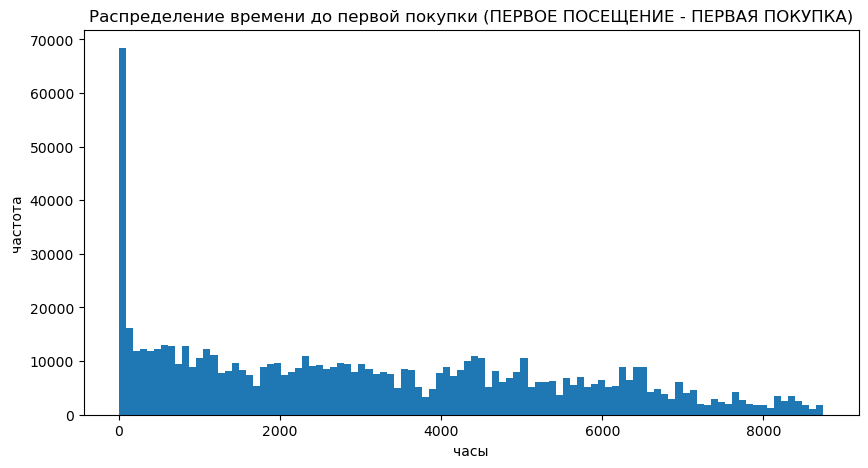

In [261]:
visit = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
visit['Start Ts'] = pd.to_datetime(visit['Start Ts'])
visit['End Ts'] = pd.to_datetime(visit['End Ts'])

first_visit = \
visit.groupby('Uid').agg({'Start Ts': 'min'}).reset_index()

visit =\
visit.merge(first_visit,
            on = 'Uid').rename({'Start Ts_x': 'start_session', 'Start Ts_y': 'start_first_session'}, axis = 1)


visit_orders_data = \
visit.merge(orders,
            on = 'Uid').rename({'Buy Ts': 'buy_ts' , 'End Ts': 'end_ts'}, axis = 1)


visit_orders_data['delta_time_hours'] = ((visit_orders_data['buy_ts'] - visit_orders_data['start_first_session']) / np.timedelta64(1,'h')).round(2)


plt.figure(figsize=(10, 5))
visit_orders_data['delta_time_hours'].plot(kind = 'hist',
                                           bins = 100)
plt.xlabel('часы')
plt.ylabel('частота')
plt.title('Распределение времени до первой покупки (ПЕРВОЕ ПОСЕЩЕНИЕ - ПЕРВАЯ ПОКУПКА)')

visit_orders_data['delta_time_hours'].describe().round(2)

In [262]:
visit_orders_data['delta_time_hours'].mode()

0    0.0
Name: delta_time_hours, dtype: float64

данные о временном промежутке ПЕРВЫЙ ВХОД - ПЕРВАЯ ПОКУПКА :

- медиана: 2832 часа
- мода: менее часа

##### 2) Сколько раз покупают за период?

In [263]:
from datetime import datetime

data_orders_log['day'] = data_orders_log['Buy Ts'].dt.date
data_orders_log['week'] = data_orders_log['Buy Ts'].dt.week
data_orders_log['month'] = data_orders_log['Buy Ts'].apply(lambda x: datetime.strftime(x, '%Y-%m'))
data_orders_log['year'] = data_orders_log['Buy Ts'].apply(lambda x: datetime.strftime(x, '%Y'))

data_orders_log.head()

C:\Users\oudel\AppData\Local\Temp\ipykernel_15192\989080798.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_orders_log['week'] = data_orders_log['Buy Ts'].dt.week


,Buy Ts,Revenue,Uid,day,week,month,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,2017-06,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,2017-06,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,2017-06,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,2017-06,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,2017-06,2017


In [264]:
data_day = data_orders_log.groupby('day')['Uid'].count()
data_week = data_orders_log.groupby('week')['Uid'].count()
data_month = data_orders_log.groupby('month')['Uid'].count()
data_year = data_orders_log.groupby('year')['Uid'].count()

data_describe =\
pd.concat([data_day.describe(),
           data_week.describe(),
           data_month.describe(),
           data_year.describe()],
           axis = 1).round(1)

data_describe.columns = ['day', 'week', 'month', 'year']

data_describe

,day,week,month,year
count,364.0,52.0,13.0,2.0
mean,138.5,969.5,3878.1,25207.5
std,76.9,397.6,1858.1,3195.4
min,1.0,314.0,1.0,22948.0
25%,82.8,658.5,2363.0,24077.8
50%,136.0,997.5,4346.0,25207.5
75%,177.0,1270.5,5326.0,26337.2
max,814.0,1894.0,6218.0,27467.0


В среднем: 

    1) в день 138 покупок
    2) в неделю 969
    3) в месяц 3878 

##### 3) Какой средний чек?

In [265]:
data_orders_log['Revenue'].describe().round(2)

count    50415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max       2633.28
Name: Revenue, dtype: float64

Text(0.5, 1.0, 'Распределение выручки')

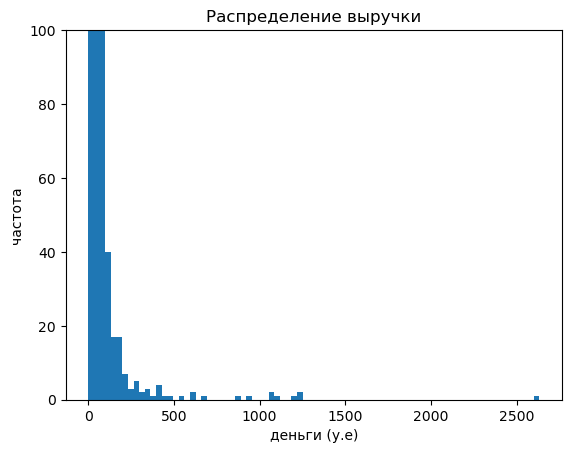

In [266]:
data_orders_log['Revenue'].plot(kind = 'hist',
                                bins = 80)
plt.ylim((0,100))
plt.xlabel('деньги (у.е)')
plt.ylabel('частота')
plt.title('Распределение выручки')

In [267]:
# уберем выбросы ---> копируем функцию фильтрации выбросов

def vibros_identification_create_filter_frame(df,                           
                                              spisok_priznakov):
    
    '''
    df - датафрейм который мы фильтруем по выбросам
    spisok_main_priznakov - список названий колонок про которым мы фильтруем выбросы

    Например: 

    spisok_main_priznakov = ['цена на момент снятия с публикации (млн. руб.)',
                             'площадь квартиры в квадратных метрах (м²)',
                             'всего этажей в доме',
                             'высота потолков (м)',
                             'площадь кухни (м²)',
                             'жилая площадь (м²)']
    '''
    
    data_new = df.copy()

    for column_name in spisok_priznakov:
        q1 = df[column_name].quantile(0.25)
        q3 = df[column_name].quantile(0.75)
        IQR = q3-q1     # интерквартильный размах 


        filter_for_kolonka = (df[column_name] >= (q1 - 1.5*IQR)) & (df[column_name] <= (q3 + 1.5*IQR))   # Получаем маску признаков без выбросов

        indexes = data_new[filter_for_kolonka].index
        data_new = data_new.loc[indexes] 
        
    return data_new         # Возвращает отфильтрованный датафрейм (отфильтрованный по выбросам)




data_order_clear = vibros_identification_create_filter_frame(data_orders_log,
                                                             ['Revenue'])


##############   Посмотрим стат. данные по очищенному dt ###############################

data_order_clear['Revenue'].describe().round(2)


count    46425.00
mean         3.02
std          2.34
min          0.00
25%          1.22
50%          2.44
75%          4.28
max         10.39
Name: Revenue, dtype: float64

Text(0.5, 1.0, 'Средний показатель выручки (в мес.) БЕЗ ВЫБРОСОВ')

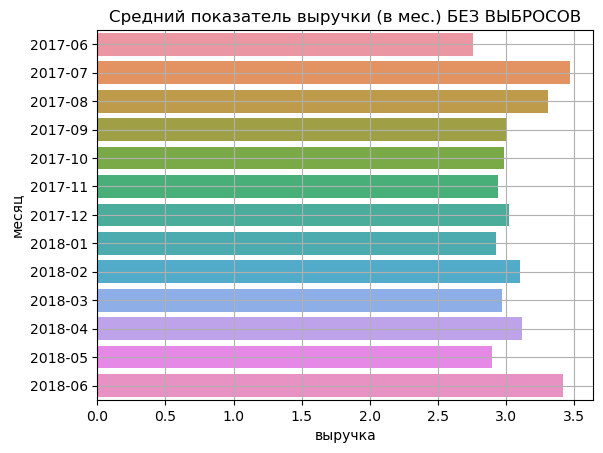

In [268]:
# имеет смысл посмотреть на средний чек помесячно

data_month_revenue =\
data_order_clear.groupby('month')['Revenue'].mean()

sns.barplot(data = data_month_revenue.reset_index(),
            x = 'Revenue',
            y = 'month')
plt.grid()
plt.xlabel('выручка')
plt.ylabel('месяц')
plt.title('Средний показатель выручки (в мес.) БЕЗ ВЫБРОСОВ')

Text(0.5, 1.0, 'Средний показатель выручки (в мес.) C ВЫБРОСАМИ')

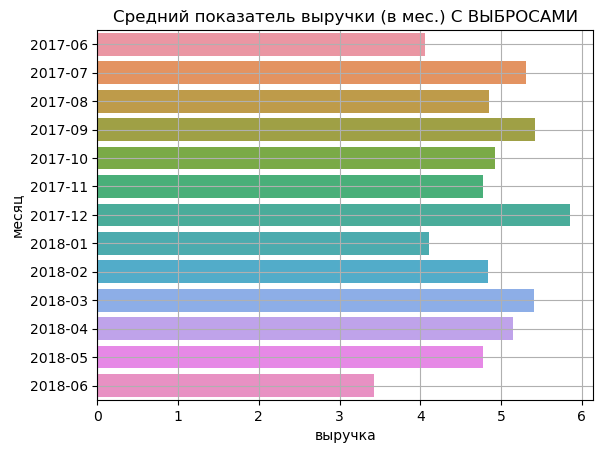

In [269]:
data_month_revenue_dirty = \
data_orders_log.groupby('month')['Revenue'].mean().round(2)

sns.barplot(data = data_month_revenue_dirty.reset_index(),
            x = 'Revenue',
            y = 'month')
plt.grid()
plt.xlabel('выручка')
plt.ylabel('месяц')
plt.title('Средний показатель выручки (в мес.) C ВЫБРОСАМИ')


        Средний чек без выбросов варируется : 2.75 - 3.4  у.е.
        Средний чек: 3.5 - 6  у.е.

##### 4) Сколько денег приносят? (LTV)

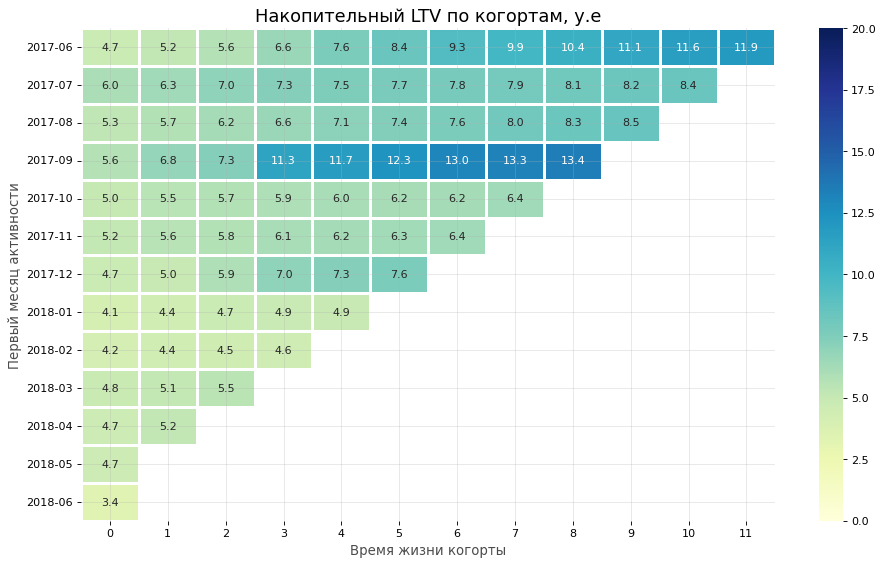

In [270]:
orders = data_orders_log[['Uid','Buy Ts','Revenue']]

# группировка по времени первой покупки
first_order_time = orders.groupby('Uid')['Buy Ts'].min().reset_index()

# соединяем данные о покупках с данными о первых покупках
orders_enhanced =\
pd.merge(orders,
         first_order_time,
         on = 'Uid').rename({'Buy Ts_x': 'buy_ts', 'Buy Ts_y': 'buy_ts_min'}, axis=1)

# меняем временные данные на исключительно месяцы
orders_enhanced['order_month'] = orders_enhanced['buy_ts'].dt.to_period('M').astype('datetime64[M]')
orders_enhanced['first_order_month'] = orders_enhanced['buy_ts_min'].dt.to_period('M').astype('datetime64[M]')

# создаем сводную таблицу по:  кол-ву уникальных пользователей/количеству покупок/сумарной выручке
orders_grouped_by_month = orders_enhanced.groupby(['first_order_month', 'order_month']).agg({'Uid' : 'nunique', 'buy_ts': 'count', 'Revenue': 'sum'}).reset_index()
orders_grouped_by_month = orders_grouped_by_month.rename({'Uid': 'users_count', 'buy_ts': 'orders_count'}, axis=1)

# подсчет кол-ва месяцев с первой покупки до последней (из представленной выборки)
orders_grouped_by_month['cohort_lifetime'] = ((orders_grouped_by_month['order_month'] - orders_grouped_by_month['first_order_month'])/np.timedelta64(1, 'M')).round().astype('int')

# начальное кол-во пользователей (в каждой из когорт) + соединение с основными данными
initial_users_count = orders_grouped_by_month[orders_grouped_by_month['cohort_lifetime'] == 0][['first_order_month', 'users_count']]
initial_users_count = initial_users_count.rename(columns = {'users_count': 'cohort_users'})
orders_grouped_by_month = orders_grouped_by_month.merge(initial_users_count, on='first_order_month')

# подсчет выручки на пользователя
orders_grouped_by_month['orders_per_user'] = orders_grouped_by_month['orders_count'] / orders_grouped_by_month['cohort_users']
orders_grouped_by_month['revenue_per_user'] = orders_grouped_by_month['Revenue'] / orders_grouped_by_month['cohort_users']
orders_grouped_by_month['first_order_month'] = orders_grouped_by_month['first_order_month'].apply(lambda x: datetime.strftime(x, '%Y-%m'))

# сводная таблица кагорт и векторное сумирование
lifetime_pivot_revenue = orders_grouped_by_month.pivot_table(index='first_order_month', columns='cohort_lifetime', values='revenue_per_user', aggfunc='sum')
lifetime_pivot_revenue = lifetime_pivot_revenue.cumsum(axis=1)

# построение таблицы когорт (накопительная)
plt.figure(figsize=(14, 8), dpi= 80)
sns.heatmap(lifetime_pivot_revenue, annot=True, fmt='.1f', linewidths=1, vmin=0, vmax=20, cmap="YlGnBu")
plt.xlabel('Время жизни когорты', alpha=.7, fontsize=12)
plt.ylabel('Первый месяц активности', alpha=.7, fontsize=12)
plt.title("Накопительный LTV по когортам, у.е", fontsize=16)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()  


Самый большой накопительный эффект был у июньских и сентябрьских когорт ---> чем дольше пользователь остается на платфоме , тем больше покупок совершает

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### [Маркетинг](stage_2_2)

##### 1) Сколько денег потратили? Всего / на каждый источник / по времени

In [271]:
all_costs = data_costs['costs'].sum()
print(f'Всего потратили за период: {all_costs} у.е.')

Всего потратили за период: 329131.62 у.е.


Text(0, 0.5, 'затраты')

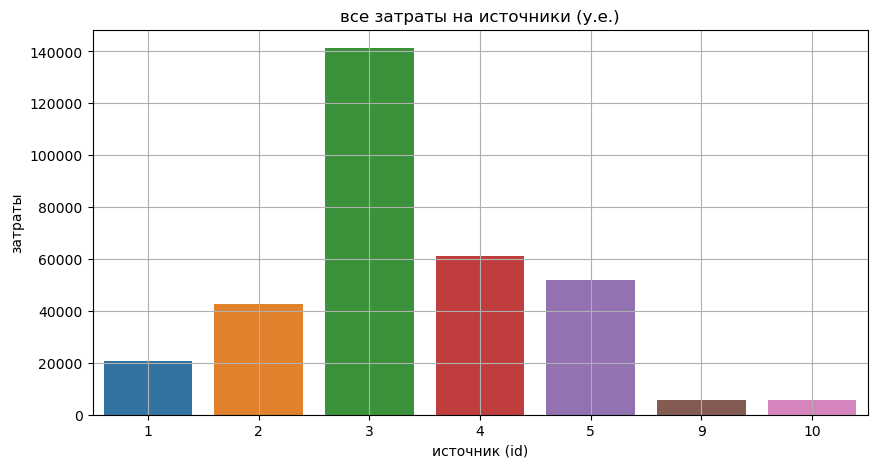

In [272]:
sources_costs =\
data_costs.pivot_table(values='costs',
                       index='source_id',
                       aggfunc='sum').reset_index()


plt.figure(figsize=(10, 5))
sns.barplot(data = sources_costs,
            y = 'costs',
            x = 'source_id')
plt.grid(visible=True)
plt.title('все затраты на источники (у.е.)')
plt.xlabel('источник (id)')
plt.ylabel('затраты')

Text(0, 0.5, 'месяц')

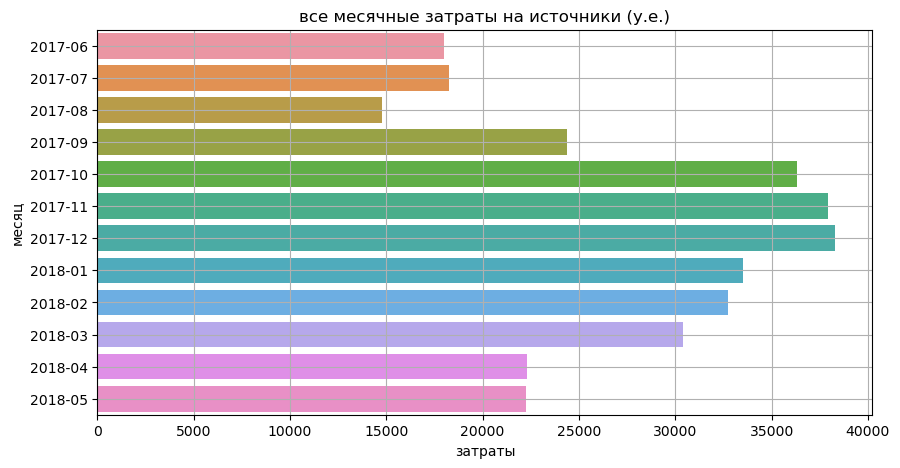

In [273]:
data_costs = data_costs.rename({'dt':'day'}, axis = 1)
data_costs['month'] = data_costs['day'].apply(lambda x: datetime.strftime(x, '%Y-%m'))

data_costs_month = \
data_costs.groupby('month').agg({'costs':'sum'}).reset_index()



plt.figure(figsize=(10, 5))
sns.barplot(data = data_costs_month,
            x = 'costs',
            y = 'month')
plt.grid(visible=True)
plt.title('все месячные затраты на источники (у.е.)')
plt.xlabel('затраты')
plt.ylabel('месяц')

    1) Все затраты: 329131.62 у.е.
    2) Самый дорогостоящий источник - 3, самый дешевый - 9,10
    3) Больше всего потратили на источники в период:  октябрь - декабрь 2017 года.

##### 2) Сколько стоило привлечение одного покупателя из каждого источника? ( CAC )

In [274]:
# расходы на все маркетинговые активности
source_costs_cac = sources_costs
source_costs_cac

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [275]:
visit_cac = data_visit_log[['Uid','Source Id','Start Ts']]

# Первый вход каждого пользователя за отчетный период
user_first_visit =\
visit_cac.groupby('Uid').agg({'Start Ts': 'min'}).reset_index().rename({'Start Ts': 'first_visit'}, axis = 1)

# Соединяем данные о старте сессий с временем первого визита
users_start_and_first_session =\
pd.merge(visit_cac,
         user_first_visit,
         on = 'Uid').rename({'Start Ts': 'start_session'}, axis = 1)

# Проверка
def proverka(row):
    if row['first_visit'] <= row['start_session']:
        return 'да'
    else:
        return 'нет'

users_start_and_first_session['True ???'] = users_start_and_first_session.apply(lambda row: proverka(row), axis = 1)
users_start_and_first_session['True ???'].unique()

array(['да'], dtype=object)

In [276]:
# Пользователи с первым визитом
data_first_visit_cac =\
users_start_and_first_session.query('start_session == first_visit')

# Объединяем с пользователями, совершившими покупку и группируем по источникам
users_cac =\
orders.merge(data_first_visit_cac,
             on = 'Uid').groupby('Source Id').agg({'Uid': 'nunique'}).reset_index().rename({'Uid': 'count_users'}, axis = 1)

users_cac

,Source Id,count_users
0,1,2964
1,2,3515
2,3,10248
3,4,10113
4,5,6847
5,7,1
6,9,1087
7,10,1306


In [277]:
CAC =\
pd.merge(source_costs_cac,
         users_cac,
         left_on= 'source_id',
         right_on= 'Source Id').drop('Source Id', axis=1)

CAC['CAC'] = (CAC['costs'] / CAC['count_users']).round(2)
CAC

,source_id,costs,count_users,CAC
0,1,20833.27,2964,7.03
1,2,42806.04,3515,12.18
2,3,141321.63,10248,13.79
3,4,61073.60,10113,6.04
4,5,51757.10,6847,7.56
5,9,5517.49,1087,5.08
6,10,5822.49,1306,4.46


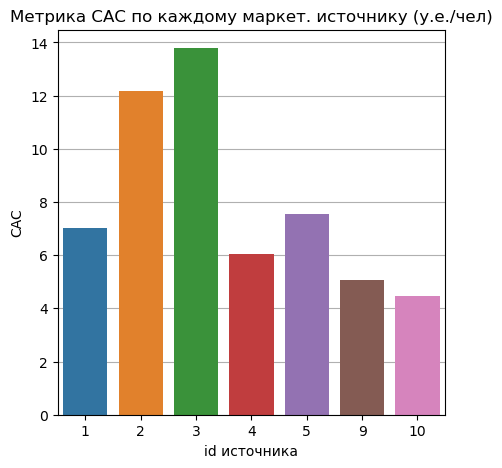

In [278]:
# строим гистограмму CAC по источниками
plt.figure(figsize=(5,5))

ax =\
sns.barplot(data = CAC,
            x = 'source_id',
            y = 'CAC')
plt.xlabel('id источника')
plt.title('Метрика САС по каждому маркет. источнику (у.е./чел)')
ax.set_axisbelow(True)
plt.grid(axis='y')

In [279]:
# Расчет CAC по устройствам

visit_device_cac = data_visit_log[['Device','Source Id','Uid', 'Start Ts', 'End Ts']]
orders_device_cac = orders[['Uid','Buy Ts']]
costs_device_cac = data_costs[['source_id','day','costs']]

costs_device_cac

,source_id,day,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [280]:
# считаем кол-во новых пользователей по устройствам
first_visit = visit_device_cac.groupby('Uid').agg({'Start Ts': 'min'}).reset_index().rename({'Start Ts': 'first_visit'}, axis=1)

count_users_device_cac =\
pd.merge(first_visit,
         visit_device_cac,
         on = 'Uid').rename({'Start Ts': 'start_session'}, axis=1) \
                    .drop('End Ts', axis=1) \
                    .query('first_visit == start_session') \
                    .groupby('Device')['Uid'].count() \
                    .reset_index() \
                    .rename({'Uid': 'count_users'}, axis = 1)

count_users_device_cac

,Device,count_users
0,desktop,147410
1,touch,59641


- самые большие затраты на привлечение одного покупателя - 14 у.е., 12 у.е. ( 3 и 2 источники соответственно )
- все остальные источники привели покупателя за цену в промежутке: 4-8 у.е.

##### 3) На сколько окупились расходы? (ROI)

In [281]:
# Общий ROI
REVENUE_ROI = orders['Revenue'].sum()
COSTS_ROI = all_costs

ROI = ((REVENUE_ROI - COSTS_ROI) / COSTS_ROI )*100
ROI

-23.41750695360112

In [282]:
# затраты по каждому источнику
source_costs_ROI = source_costs_cac

# данные визитов уникальных пользователей
data_first_visit_ROI = data_first_visit_cac[['Uid','Source Id','start_session','first_visit']]

# доход по каждому источнику
source_revenue_ROI =\
orders.merge(data_first_visit_ROI,
             on = 'Uid').groupby('Source Id').agg({'Revenue':'sum'}).reset_index()

source_revenue_ROI

,Source Id,Revenue
0,1,30537.37
1,2,47265.19
2,3,53061.62
3,4,55601.15
4,5,53352.23
5,7,1.22
6,9,5746.85
7,10,4611.73


In [283]:
ROI =\
pd.merge(source_costs_ROI,
         source_revenue_ROI,
         left_on = 'source_id',
         right_on='Source Id').drop('Source Id', axis = 1)

ROI['ROI(%)'] = (((ROI['Revenue'] - ROI['costs'])/ ROI['costs'])*100).round(1)
ROI

,source_id,costs,Revenue,ROI(%)
0,1,20833.27,30537.37,46.6
1,2,42806.04,47265.19,10.4
2,3,141321.63,53061.62,-62.5
3,4,61073.60,55601.15,-9.0
4,5,51757.10,53352.23,3.1
5,9,5517.49,5746.85,4.2
6,10,5822.49,4611.73,-20.8


Есть окупившиеся маркетинговые ходы, есть не окупившиеся.
- Лучший источник по окупаемости: 1
- Худший: 3

##### 4) Доход по устройствам ?

In [284]:
visit_revenue_device = data_visit_log[['Device','Source Id','Uid','Start Ts','End Ts']].rename({'Start Ts': 'start_session', 'End Ts': 'end_session'}, axis = 1)
orders_revenue_device = orders.rename({'Buy Ts': 'buy_time'}, axis=1)

first_visit_device_revenue = visit_revenue_device.groupby('Uid').agg({'start_session': 'min'}).reset_index().rename({'start_session': 'first_visit'}, axis=1)


itog =\
pd.merge(first_visit_device_revenue,
         visit_revenue_device,
         on = 'Uid').query('start_session == first_visit').merge(orders_revenue_device,
                                                                 on = 'Uid')

itog.head()    # длина этого датафрейма не соответствует длине orders т.к. не все визиты отражены в visit


,Uid,first_visit,Device,Source Id,start_session,end_session,buy_time,Revenue
0,313578113262317,2017-09-18 22:49:00,desktop,2,2017-09-18 22:49:00,2017-09-18 23:07:00,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,touch,10,2017-06-03 10:13:00,2017-06-03 10:17:00,2017-06-03 10:13:00,1.22
2,1575281904278712,2017-06-03 10:13:00,touch,10,2017-06-03 10:13:00,2017-06-03 10:17:00,2017-06-03 17:39:00,1.83
3,2429014661409475,2017-10-11 17:14:00,desktop,3,2017-10-11 17:14:00,2017-10-11 17:27:00,2017-10-11 18:33:00,73.33
4,2464366381792757,2018-01-27 20:10:00,desktop,5,2018-01-27 20:10:00,2018-01-27 20:13:00,2018-01-28 15:54:00,2.44


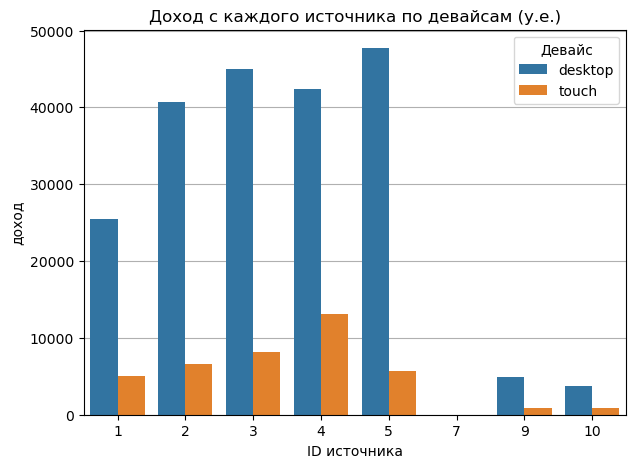

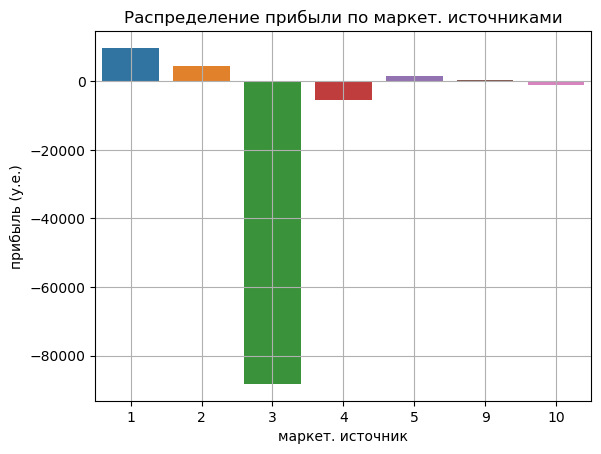

,source_id,Revenue,costs,profit
0,1,30537.37,20833.27,9704.10
1,2,47265.19,42806.04,4459.15
2,3,53061.62,141321.63,-88260.01
3,4,55601.15,61073.60,-5472.45
4,5,53352.23,51757.10,1595.13
5,9,5746.85,5517.49,229.36
6,10,4611.73,5822.49,-1210.76


In [285]:
device_source_revenue =\
itog.groupby(['Device', 'Source Id']).agg({'Revenue': 'sum'}).reset_index()

plt.figure(figsize=(7, 5))
ax =\
sns.barplot(data = device_source_revenue,
            hue = 'Device',
            x = 'Source Id',
            y = 'Revenue')
plt.title('Доход с каждого источника по девайсам (у.е.)')
plt.xlabel('ID источника')
plt.ylabel('доход')
plt.legend(title = 'Девайс')
plt.grid(axis = 'y')
ax.set_axisbelow(True)
plt.show()

# посмотрим на прибыль по источникам
source_revenue =\
device_source_revenue.groupby('Source Id').agg({'Revenue': 'sum'}).reset_index().rename({'Source Id': 'source_id'}, axis = 1)
source_costs =\
data_costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()

source_profit =\
pd.merge(source_revenue,
         source_costs,
         on = 'source_id')

source_profit['profit'] = source_profit['Revenue'] - source_profit['costs']

sns.barplot(data = source_profit,
            x = 'source_id',
            y = 'profit')
plt.grid()
plt.title('Распределение прибыли по маркет. источниками')
plt.xlabel('маркет. источник')
plt.ylabel('прибыль (у.е.)')
plt.show()

source_profit


In [286]:
costs_to_raspredelenie = source_profit.query('profit < 0')['profit'].sum() * (-1)
summ_profit = source_profit.query('profit > 0')['profit'].sum()

source_profit['new_costs'] = np.zeros(len(source_profit))

def zamena(row):
    if row['profit']<0:
        row['new_costs'] = row['costs'] + row['profit']
        return row['new_costs']
    else:
        dolya = row['profit']/summ_profit
        row['new_costs'] = row['costs'] + dolya*costs_to_raspredelenie
        return row['new_costs']


    
    
source_profit['new_costs'] = source_profit.apply(lambda row: zamena(row), axis = 1)
source_profit.round(2)

,source_id,Revenue,costs,profit,new_costs
0,1,30537.37,20833.27,9704.10,78461.08
1,2,47265.19,42806.04,4459.15,69286.71
2,3,53061.62,141321.63,-88260.01,53061.62
3,4,55601.15,61073.60,-5472.45,55601.15
4,5,53352.23,51757.10,1595.13,61229.78
5,9,5746.85,5517.49,229.36,6879.54
6,10,4611.73,5822.49,-1210.76,4611.73


доход с компьтерных посещений намного выше по всем источникам

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?](stage_3)

- Какие источники/платформы вы бы порекомендовали? 
- Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? 
- Какие выводы вы сделали, узнав значение метрик?

Вывод:


- рекламные компании (или их отсутствие) влекут за собой изменения в кол-ве посещений сайта
- люди (при прочих равных) стабильно посещают в день
- навигация сайта - хорошая ( длительность сессии - 1 минута )
- наибольшая активность пользователей в летние месяцы
- средний чек - 3.5 - 6 у.е.
- самый дорогой маркетинговый источник - 3
- самый дешевый маркетинговый источник - 9/10
- самые большие траты на маркет. источники в октябре-декабре
- самые большие затраты на привлечение одного покупателя - 14 у.е., 12 у.е. ( 3 и 2 источники соответственно )
- все остальные источники привели покупателя за цену в промежутке: 4-8 у.е.
- лучшая окупаемость у 1-го источника, худшая у 3-го
- доходы с компьютеров - сильно опережают доходы с телефонов


Рекомендации:

- при расширении аудитории - сделать фокус на ЦА ( грамотные рекламные компании или програмное вмешательство: "ЦА - афиша" подбирать афишу под конкретную ЦА ) видно по метрике Retention Rate - аудитория растет, а активность снижается
- при первом посещении сайта предлагать бонусы (разного вида, в зависимости от возможностей компании) для сокращения времени ПЕРВЫЙ ВХОД - ПОКУПКА, и дальнейшее поддержание бонусов, для повышения активности пользователей
- не обращать внимание на средний чек ( мероприятия - сезонное явление, на з/п пользователей не повлиять, "если он работает не в Яндексе" :) )
- продумать возможности удержания клиента (Например: добавлять ЯА в доп. услуги других сервисов Я)
- решить проблему несоответствия visit_data и orders_data (почему-то некоторые покупки не входят в интервалы между входом в сессию и выходом из нее)
- при выборе трат рекламных бюджетов ----> фокус на ПК а не на смартфоны

##### План по распределению затрат на маркет. источники:

Сократить затраты на неприбыльные источники до 0 и равномерно распределить между прибыльными источниками, как расчитано в последней ячейке (стобец new_costs - это сколько нужно тратить на каждый источник сумарно за отведенный период)

